Import necessary libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install tensorflow
!pip install keras

# Preprocessing
Preparing Data For Training Fine-Tuned VGG-16 Model.
This involves loading the dataset, performing image augmentation, and dividing the data into training and validation sets.



To make the task more efficient, we reorganised the dataset. Initially, the KDEF dataset was organised in folders by subject, but I would like it to be organised by emotion. The name of each file is meaningful.

###KDEF
The Karolinska Directed Emotional Faces; 4900 pictures on facial emotional expressions.


**Session-Gender-Identity number**(01 - 35)

      A = series one; B = series two
      F = female; M = male

      
**Letter 5 & 6: Expression**

      AF = afraid
      AN = angry
      DI = disgusted
      HA = happy
      NE = neutral
      SA = sad
      SU = surprised
**Letter 7 & 8: Angle**

      FL = full left profile
      HL = half left profile
      S = straight
      HR = half right profile
      FR = full right profile

So in order to extract informations we need:

        emozione = filename[4:6]
        angle = filename[6:8]

"emozione" will be the name of new folders and we used angle to filter front faces (minimal dataset).


In [4]:
!unzip /content/drive/MyDrive/ColabNotebooks/AsItSounds/FacialExpRecognition/KDEF.zip -d KDEF

Streaming output truncated to the last 5000 lines.
  inflating: KDEF/KDEF/AF02/AF02AFHR.JPG  
  inflating: KDEF/KDEF/AF02/AF02AFS.JPG  
  inflating: KDEF/KDEF/AF02/AF02ANFL.JPG  
  inflating: KDEF/KDEF/AF02/AF02ANFR.JPG  
  inflating: KDEF/KDEF/AF02/AF02ANHL.JPG  
  inflating: KDEF/KDEF/AF02/AF02ANHR.JPG  
  inflating: KDEF/KDEF/AF02/AF02ANS.JPG  
  inflating: KDEF/KDEF/AF02/AF02DIFL.JPG  
  inflating: KDEF/KDEF/AF02/AF02DIFR.JPG  
  inflating: KDEF/KDEF/AF02/AF02DIHL.JPG  
  inflating: KDEF/KDEF/AF02/AF02DIHR.JPG  
  inflating: KDEF/KDEF/AF02/AF02DIS.JPG  
  inflating: KDEF/KDEF/AF02/AF02HAFL.JPG  
  inflating: KDEF/KDEF/AF02/AF02HAFR.JPG  
  inflating: KDEF/KDEF/AF02/AF02HAHL.JPG  
  inflating: KDEF/KDEF/AF02/AF02HAHR.JPG  
  inflating: KDEF/KDEF/AF02/AF02HAS.JPG  
  inflating: KDEF/KDEF/AF02/AF02NEFL.JPG  
  inflating: KDEF/KDEF/AF02/AF02NEFR.JPG  
  inflating: KDEF/KDEF/AF02/AF02NEHL.JPG  
  inflating: KDEF/KDEF/AF02/AF02NEHR.JPG  
  inflating: KDEF/KDEF/AF02/AF02NES.JPG  
  inflat

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import shutil


# Define the path to the dataset directory
dataset_path = "/content/KDEF/KDEF"

# Create a list of possible emotions
emozioni = ["AF", "AN", "DI", "HA", "NE", "SA", "SU"]

# Navigate through each patient in the dataset directory
for paziente in os.listdir(dataset_path):
    paziente_path = os.path.join(dataset_path, paziente)

    # Go through every patient file
    for filename in os.listdir(paziente_path):
        # Extract emotion and angle from the file name
        emozione = filename[4:6]
        angle = filename[6:8]

        # Check whether the emotion is among those defined
        if emozione in emozioni:
            # Create the emotion directory if it does not already exist
            emozione_path = os.path.join(dataset_path, emozione)
            if not os.path.exists(emozione_path):
                os.makedirs(emozione_path)

            # Move the file to the directory corresponding to the emotion
            shutil.move(os.path.join(paziente_path, filename), os.path.join(emozione_path, filename))

# Define dataset and saved model paths
DATASET_DIR = "/content/KDEF/KDEF"
SAVED_MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/AsItSounds/Saved Models/KDEF/full_kdef_VGG16_finetuned.h5"

# Define training parameters
BATCH_SIZE = 64
IMG_SIZE = (224, 224) # Dimensions of input images
N_EPOCHS = 50
LEARNING_RATE = 0.00001

# Delete unnecessary folders
for nome_cartella in os.listdir(dataset_path):
    if nome_cartella not in emozioni:
        cartella_da_eliminare = os.path.join(dataset_path, nome_cartella)
        shutil.rmtree(cartella_da_eliminare)  # Delete the folder and its contents

##### Stratified split into train, validation and test ####
image_paths = []
labels = []
for emozione in emozioni:
    emozione_path = os.path.join(dataset_path, emozione)
    for filename in os.listdir(emozione_path):
        image_paths.append(os.path.join(emozione_path, filename))
        labels.append(emozione)

# Split dataset into train set and test set (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Split of the train set into train and validation (80%-20% of the original train)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# Creation of data generators for augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rotation_range=20, # Randomly rotates images by up to 20 degrees
    width_shift_range=0.2, # Randomly shifts images horizontally by up to 20% of the width
    height_shift_range=0.2, # Randomly shifts images vertically by up to 20% of the height
    horizontal_flip=True, # Randomly flips images horizontally
    rescale=1./255, # Rescales pixel values to be between 0 and 1
    zoom_range=0.1, # Randomly zooms in or out on images by up to 10%
)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255 # Only rescaling for the test set
)


test_datagen = ImageDataGenerator(
    rescale=1.0 / 255  # Only rescaling for the test set
)

train_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({"filename": X_train, "class": y_train}),
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
)

validation_generator = val_datagen.flow_from_dataframe(
    pd.DataFrame({"filename": X_val, "class": y_val}),
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

test_generator = test_datagen.flow_from_dataframe(
    pd.DataFrame({"filename": X_test, "class": y_test}),
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)


Found 3134 validated image filenames belonging to 7 classes.
Found 784 validated image filenames belonging to 7 classes.
Found 980 validated image filenames belonging to 7 classes.


# VGG 16

Fine Tuning VGG-16 Pre-Trained Model.

This section involves loading the pre-trained VGG-16 model, freezing the initial layers to preserve pre-learned features, adding custom layers for the specific task, and compiling the model with an appropriate optimizer, loss function, and metrics.

*Why have we added these particular layers?*

1. **Increased Learning Capacity**: The dense layers with numerous neuron (4096) increase the model's ability to learn complex representations from data. This is particularly useful when working with classification tasks that require fine discrimination between classes as in the case of the facial emotion recognition task.

2.  **Overfitting Prevention**: Dropout layers reduce the risk of overfitting,thus improving the generalisation of the model to unseen data. This is crucial when adding capacity to the model to prevent it from learning the training data completely by memory.

3. **Specific Fitting**: Freezing the first layers of the VGG-16 model allows it to take advantage of pre-trained generic features, while fine-tuning the last layers and adding new dense layers allows the model to better fit the specific features of the new dataset.

4. **Specific output**: The final layer with the softmax activation feature and the number of neurons equal to the number of classes in the dataset allows the model to produce output that can be interpreted as probabilities for each class, facilitating accurate image classification.


In [ ]:
import tensorflow as tf
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.losses import categorical_crossentropy


# Load the pre-trained VGG-16 model
vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze layers for transfer learning
# This prevents the weights of these layers from being updated during training,
# which helps to preserve the pre-learned features.
for layer in vgg_model.layers[:-5]:  # Fine-tune the last few blocks
    layer.trainable = False # Freezes all layers except the last five block

# Adding flatten and dense layers to vgg-16 in order final model
output = vgg_model.output
output = Flatten()(output) # Flattens the output from the VGG-16 model
output = Dense(4096, activation='relu')(output)  # Increased neurons
output = Dropout(0.5)(output) # Adds a dropout layer to prevent overfitting
output = Dense(4096, activation='relu')(output)  # Increased neurons
output = Dropout(0.5)(output)
# Adds the final output layer with a softmax activation
output = Dense(len(train_generator.class_indices), activation='softmax')(output)
final_model = Model(inputs=vgg_model.inputs, outputs=output) # Creates the final model

# Initializing the Adam optimizer
opt = Adam(learning_rate=LEARNING_RATE)

# Compiling the model
final_model.compile(
    optimizer=opt,
    loss=categorical_crossentropy, # Uses categorical crossentropy as the loss function
    metrics=["accuracy"] # Uses accuracy as the evaluation met
)


if __name__ == '__main__':
    # Make sure we have frozen the correct layers
    for i, layer in enumerate(vgg_model.layers):
        tf.print(i, layer.name, layer.trainable)

    # Displaying vgg-16 model summary
    vgg_model.summary()

    # Displaying final model summary
    final_model.summary()


0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0        

# Training

This section covers the training process of the fine-tuned model. This includes defining a learning rate scheduler, implementing early stopping and model checkpointing, and training the model using the training and validation data generators.

In [ ]:
from math import ceil
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

# Define learning rate scheduler
# This function adjusts the learning rate during training based on the current epoch.
def lr_scheduler(epoch, lr):
    if epoch < 10: # Keep the learning rate constant for the first 10 epochs
        return lr
    else: # Reduce the learning rate exponentially after 10 epochs
        return lr * tf.math.exp(-0.1)

# Implement Early Stopping and Model Checkpoint
# Early stopping helps prevent overfitting by stopping the training process if the model's
# performance on the validation set stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Stops training if validation loss doesn't improve for 10 epochs
model_checkpoint = ModelCheckpoint(SAVED_MODEL_PATH, monitor='val_loss', save_best_only=True) # Saves the model with the lowest validation loss
lr_schedule = LearningRateScheduler(lr_scheduler)

# Displaying final model summary
final_model.summary()

# Train Section
history = final_model.fit(
    train_generator,
    steps_per_epoch=ceil(train_generator.samples // BATCH_SIZE), # Calculates the number of steps per epoch
    epochs=N_EPOCHS,
    validation_data=validation_generator,
    validation_steps=ceil(validation_generator.samples // BATCH_SIZE),
    callbacks=[early_stopping, model_checkpoint, lr_schedule],
    verbose=1
)

# Saving the trained model
path = "/content/drive/MyDrive/Colab Notebooks/AsItSounds/Saved Models/KDEF"
final_model.save(filepath=path)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 87s 2s/step - loss: 2.1799 - accuracy: 0.1427 - val_loss: 1.9404 - val_accuracy: 0.1797 - lr: 1.0000e-05
Epoch 2/50
48/48 [==============================] - 87s 2s/step - loss: 2.0554 - accuracy: 0.1664 - val_loss: 1.8802 - val_accuracy: 0.2240 - lr: 1.0000e-05
Epoch 3/50
48/48 [==============================] - 97s 2s/step - loss: 1.9654 - accuracy: 0.1870 - val_loss: 1.8257 - val_accuracy: 0.2305 - lr: 1.0000e-05
Epoch 4/50
48/48 [==============================] - 87s 2s/step - loss: 1.8706 - accuracy: 0.2296 - val_loss: 1.7140 - val_accuracy: 0.3307 - lr: 1.0000e-05
Epoch 5/50
48/48 [==============================] - 94s 2s/step - loss: 1.7709 - accuracy: 0.2818 - val_loss: 1.6249 - val_accuracy: 0.3359 - lr: 1.0000e-05
Epoch 6/50
48/48 [==============================] - 86s 2s/step - loss: 1.6525 - accuracy: 0.3300 - val_loss: 1.5371 - val_accuracy: 0.3867 - lr: 1.0000e-05
Epoch 7/50
48/48 [==============================] - 91s 2s/step - los

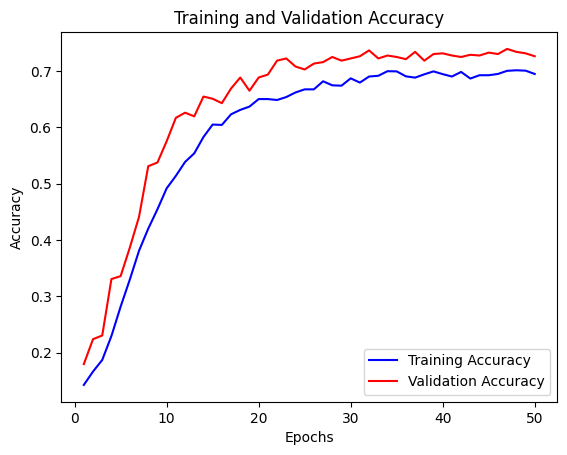

In [ ]:
import matplotlib.pyplot as plt

# Estrai l'accuracy dal training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotta l'accuracy
epochs = range(1, len(train_accuracy) + 1)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Merge train and validation set
X_train_val = X_train + X_val
y_train_val = y_train + y_val

# Create a generator for train+validation
train_val_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({"filename": X_train_val, "class": y_train_val}),
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
)

# Train the model on train+validation
history = final_model.fit(
    train_val_generator,
    steps_per_epoch=ceil(len(X_train_val) // BATCH_SIZE),
    epochs=10,
    callbacks=[early_stopping, model_checkpoint, lr_schedule],
    verbose=1
)

# Final evaluation on the test set
test_loss, test_acc = final_model.evaluate(test_generator)
print("Loss sul test set:", test_loss)
print("Accuratezza sul test set:", test_acc)

Found 3918 validated image filenames belonging to 7 classes.
Epoch 1/10
61/61 [==============================] - ETA: 0s - loss: 0.8209 - accuracy: 0.6946

61/61 [==============================] - 69s 1s/step - loss: 0.8209 - accuracy: 0.6946 - lr: 1.1109e-07
Epoch 2/10
61/61 [==============================] - ETA: 0s - loss: 0.8132 - accuracy: 0.6951

61/61 [==============================] - 69s 1s/step - loss: 0.8132 - accuracy: 0.6951 - lr: 1.1109e-07
Epoch 3/10
61/61 [==============================] - ETA: 0s - loss: 0.8102 - accuracy: 0.6845

61/61 [==============================] - 66s 1s/step - loss: 0.8102 - accuracy: 0.6845 - lr: 1.1109e-07
Epoch 4/10
61/61 [==============================] - ETA: 0s - loss: 0.8300 - accuracy: 0.6814

61/61 [==============================] - 69s 1s/step - loss: 0.8300 - accuracy: 0.6814 - lr: 1.1109e-07
Epoch 5/10
61/61 [==============================] - ETA: 0s - loss: 0.8158 - accuracy: 0.6873

61/61 [==============================] - 67s 1s/step - loss: 0.8158 - accuracy: 0.6873 - lr: 1.1109e-07
Epoch 6/10
61/61 [==============================] - ETA: 0s - loss: 0.8181 - accuracy: 0.6959

61/61 [==============================] - 68s 1s/step - loss: 0.8181 - accuracy: 0.6959 - lr: 1.1109e-07
Epoch 7/10
61/61 [==============================] - ETA: 0s - loss: 0.8107 - accuracy: 0.7011

61/61 [==============================] - 69s 1s/step - loss: 0.8107 - accuracy: 0.7011 - lr: 1.1109e-07
Epoch 8/10
61/61 [==============================] - ETA: 0s - loss: 0.8214 - accuracy: 0.6868

61/61 [==============================] - 69s 1s/step - loss: 0.8214 - accuracy: 0.6868 - lr: 1.1109e-07
Epoch 9/10
61/61 [==============================] - ETA: 0s - loss: 0.8089 - accuracy: 0.6972

61/61 [==============================] - 68s 1s/step - loss: 0.8089 - accuracy: 0.6972 - lr: 1.1109e-07
Epoch 10/10
61/61 [==============================] - ETA: 0s - loss: 0.8099 - accuracy: 0.6928

16/16 [==============================] - 12s 742ms/step - loss: 0.6821 - accuracy: 0.7551
Loss sul test set: 0.6820552349090576
Accuratezza sul test set: 0.7551020383834839


Etichetta AF: 448 immagini
Etichetta AN: 448 immagini
Etichetta DI: 448 immagini
Etichetta HA: 448 immagini
Etichetta NE: 448 immagini
Etichetta SA: 447 immagini
Etichetta SU: 447 immagini


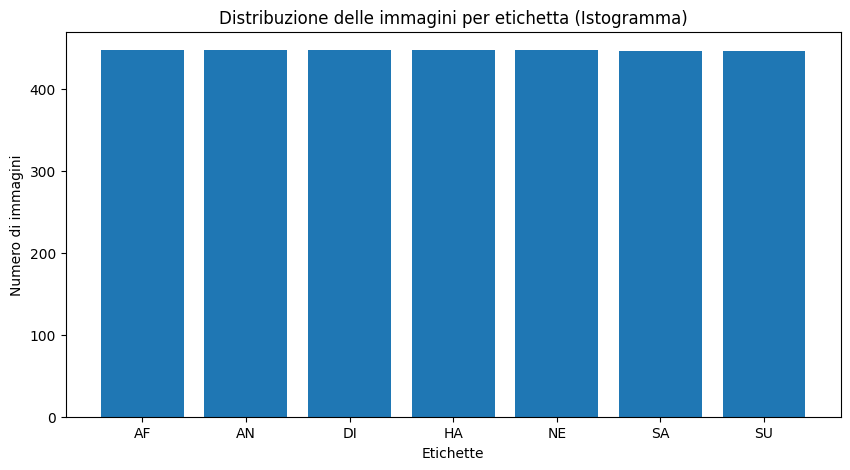

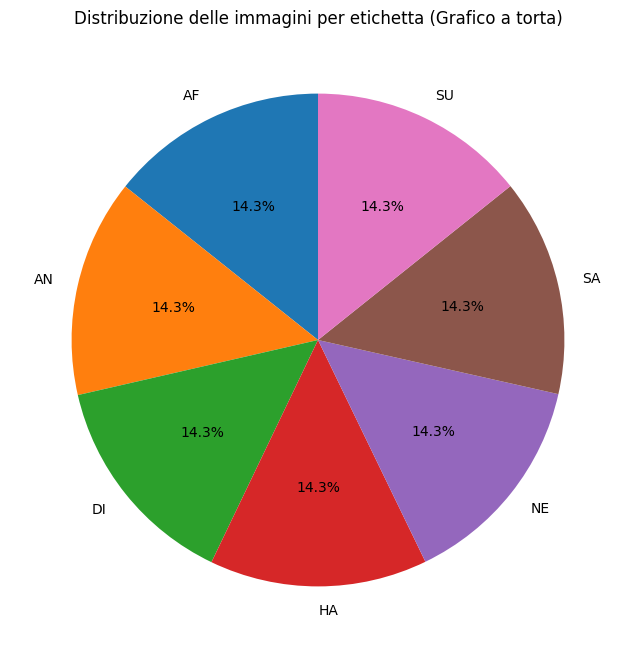

In [ ]:
import numpy as np

# Count the number of images per label
unique_labels, counts = np.unique(y_train, return_counts=True)
  # unique_labels: This variable stores an array containing the unique labels present in y_train.
  # counts: This variable stores an array containing the count of each unique label, i.e. how many times each label appears in y_train.
  # return_counts=True: This argument tells the function np.unique to return both unique labels and their counts.

# For each pair of label and count, prints a line indicating how many images are associated with that particular label
for label, count in zip(unique_labels, counts):
    print(f"Etichetta {label}: {count} immagini")

# Histogram
plt.figure(figsize=(10, 5))
plt.bar(unique_labels, counts)
plt.xlabel("Etichette")
plt.ylabel("Numero di immagini")
plt.title("Distribuzione delle immagini per etichetta (Istogramma)")
plt.xticks(unique_labels)
plt.show()

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=unique_labels, autopct="%1.1f%%", startangle=90)
plt.title("Distribuzione delle immagini per etichetta (Grafico a torta)")
plt.show()

Etichetta AF: 700 immagini
Etichetta AN: 700 immagini
Etichetta DI: 700 immagini
Etichetta HA: 700 immagini
Etichetta NE: 700 immagini
Etichetta SA: 699 immagini
Etichetta SU: 699 immagini


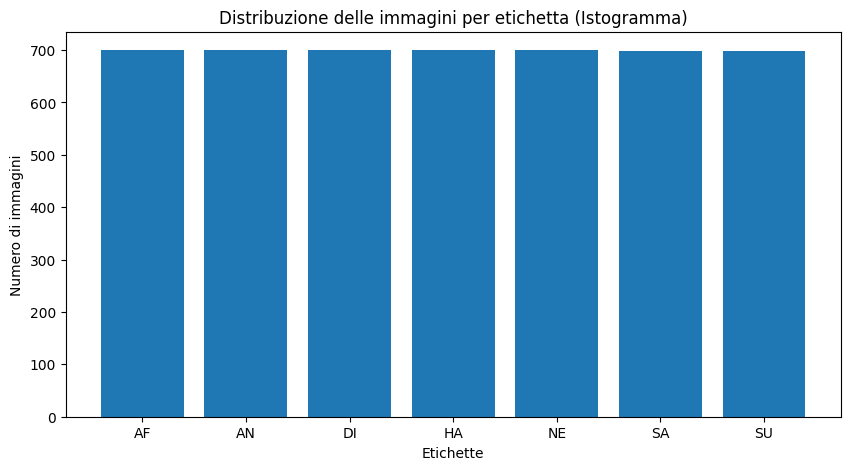

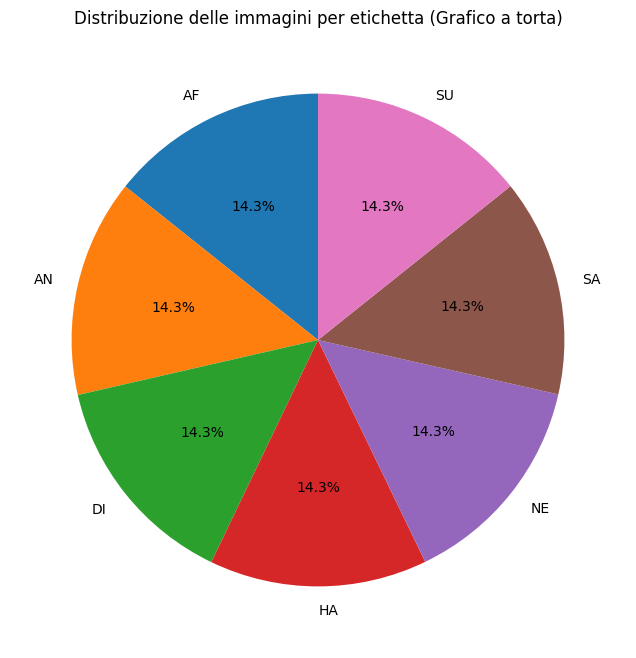

In [8]:
import numpy as np
import matplotlib.pyplot as plt

#Same as before but for the whole dataset
y_tot = y_train + y_val + y_test

unique_labels, counts = np.unique(y_tot, return_counts=True)

for label, count in zip(unique_labels, counts):
    print(f"Etichetta {label}: {count} immagini")

plt.figure(figsize=(10, 5))
plt.bar(unique_labels, counts)
plt.xlabel("Etichette")
plt.ylabel("Numero di immagini")
plt.title("Distribuzione delle immagini per etichetta (Istogramma)")
plt.xticks(unique_labels)
plt.show()

plt.figure(figsize=(8, 8))
plt.pie(counts, labels=unique_labels, autopct="%1.1f%%", startangle=90)
plt.title("Distribuzione delle immagini per etichetta (Grafico a torta)")
plt.show()